# Introduction

This notebook has the basic steps for getting a model up and running on a new set of data. 
## Steps
1. Exploratory data analysis (EDA)
2. Preprocessing
3. Model selection
4. Model implementation
5. Model evaluation
6. Improvements

I hope you have fun with this notebook! 

### 0. Import libraries and get data

To help this notebook be self-contained, I have generated some data. 

In [1]:
# Let's import the libraries we need

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Let's generate some data to play with. 

data = pd.DataFrame()

data['col0'] = np.random.randint(20, 50, [10000])
data['col1'] = np.random.randn(10000)
data['col2'] = 0
data['col3'] = np.random.uniform(0, 5000, [10000])
data['col4'] = np.random.randint(0, 5, [10000])
data['output0'] = 20*data.col0 + 0.01*data.col3 + 10*data.col1 + 5*np.random.randn(10000)
data['output1'] = np.sign(data.output0 - 700)/2 + 0.5

data.head()

,col0,col1,col2,col3,col4,output0,output1
0,48,0.456331,0,2534.593381,2,993.498641,1.0
1,46,1.202380,0,1627.906920,3,951.408568,1.0
2,36,0.457659,0,3874.080099,3,767.968703,1.0
3,20,-0.520298,0,1111.439179,1,406.437754,0.0
4,32,-0.680070,0,920.789426,4,646.856820,0.0


In [3]:
# Other useful options

# pd.set_option()
# pd.read_csv("filename")

### 1. Exploratory data analysis

In [4]:
data.describe()

,col0,col1,col2,col3,col4,output0,output1
count,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,34.467200,-0.005452,0.0,2509.663635,1.987900,714.384022,0.527400
std,8.656571,0.992867,0.0,1434.924298,1.421674,174.117942,0.499274
min,20.000000,-3.924440,0.0,0.205664,0.000000,376.372089,0.000000
25%,27.000000,-0.679246,0.0,1270.807926,1.000000,563.999970,0.000000
50%,35.000000,-0.018585,0.0,2515.205503,2.000000,716.277011,1.000000
75%,42.000000,0.657972,0.0,3745.068444,3.000000,864.186710,1.000000
max,49.000000,3.868165,0.0,4998.968307,4.000000,1055.584928,1.000000


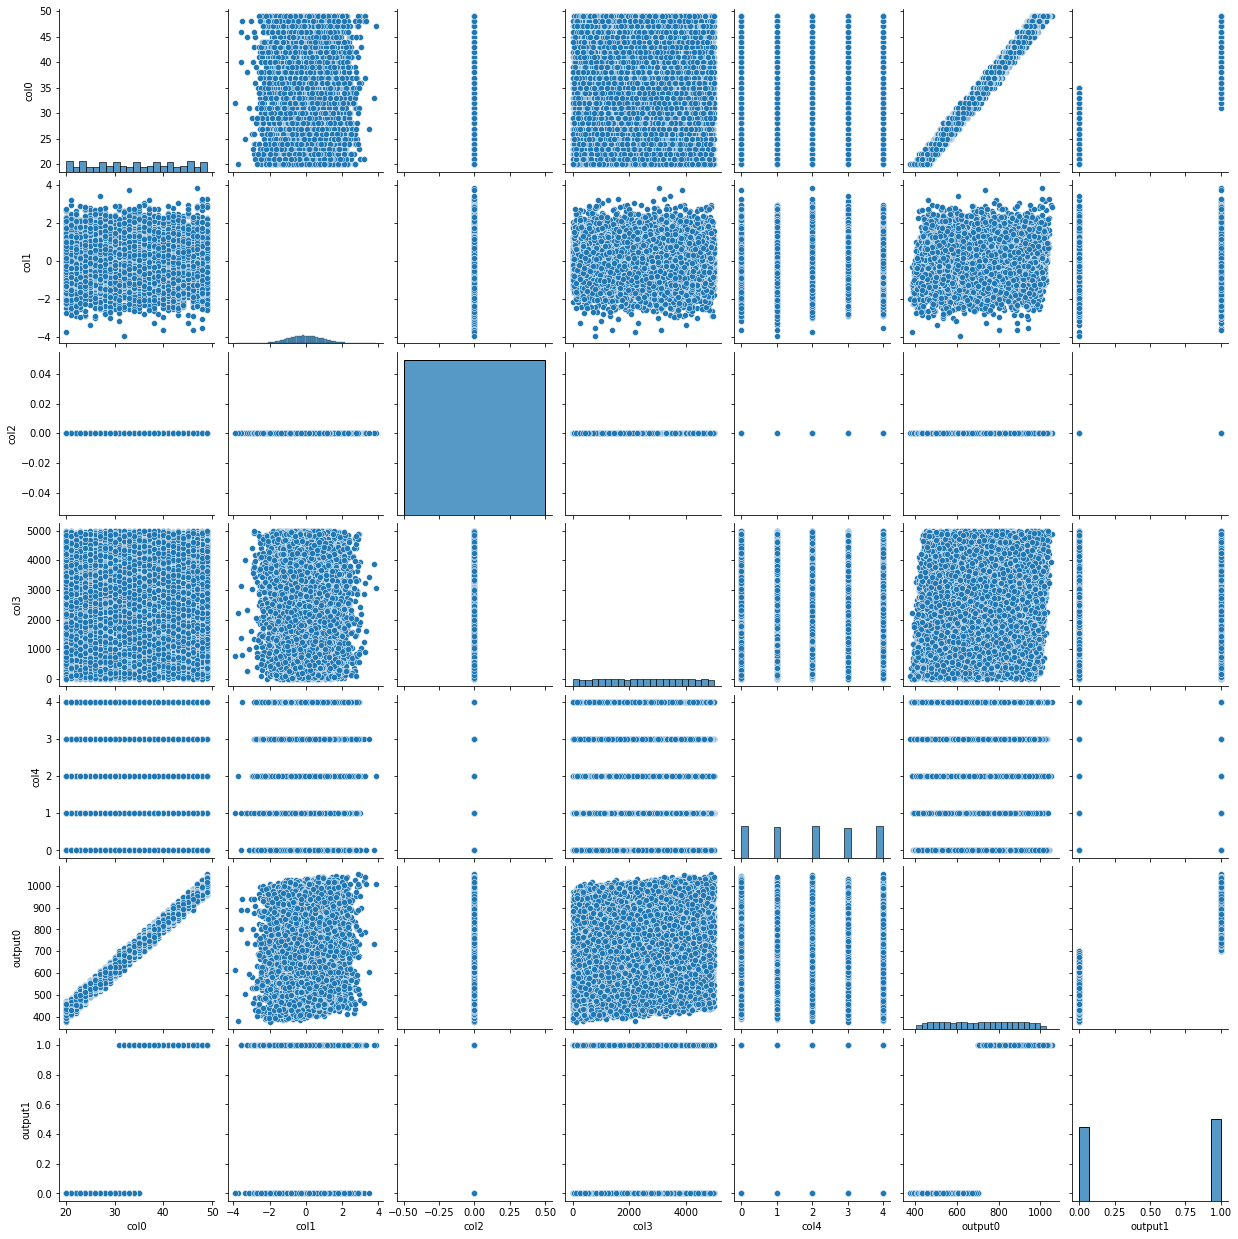

In [5]:
sns.pairplot(data)
plt.show()

In [6]:
# Contingency table for categorical variables

pd.crosstab(data.col4, data.output1, margins=True) # also an option: normalize=True

output1,0.0,1.0,All
col4,,,
0,962,1079,2041
1,953,1054,2007
2,958,1062,2020
3,891,1005,1896
4,962,1074,2036
All,4726,5274,10000


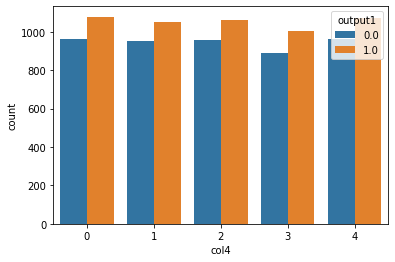

In [7]:
sns.countplot(x="col4", hue="output1", data=data)
plt.show()

In [8]:
# Other EDA options

# data.describe(include=["object", "bool"])
# print(data.shape)
# print(data.columns)
# print(data.info)
# data.[column].value_counts()
# data.sort_values(by=["col0", "col1"], ascending=[True, False])
# data.loc[rows, columns]
# data.iloc[rows, columns]
# data.drop_duplicates(axis=0)

### 2. Preprocessing

In [9]:
# drop 0 columns
data = data.drop(['col2'], axis=1)
data

,col0,col1,col3,col4,output0,output1
0,48,0.456331,2534.593381,2,993.498641,1.0
1,46,1.202380,1627.906920,3,951.408568,1.0
2,36,0.457659,3874.080099,3,767.968703,1.0
3,20,-0.520298,1111.439179,1,406.437754,0.0
4,32,-0.680070,920.789426,4,646.856820,0.0
...,...,...,...,...,...,...
9995,20,1.008974,4437.355656,3,457.384971,0.0
9996,36,1.186379,2283.349039,2,760.147817,1.0
9997,29,0.180405,4863.247341,3,629.831007,0.0
9998,46,-0.246794,3319.886558,1,941.277108,1.0


In [10]:
# one hot encode categorical data
# we have multiple columns of categorical data 
# data.col0 could be categorical but it might actually be similar to continuous data (e.g. age)

one_hot_columns = pd.get_dummies(data, columns = ['col4'], dtype='int')
one_hot_columns

,col0,col1,col3,output0,output1,col4_0,col4_1,col4_2,col4_3,col4_4
0,48,0.456331,2534.593381,993.498641,1.0,0,0,1,0,0
1,46,1.202380,1627.906920,951.408568,1.0,0,0,0,1,0
2,36,0.457659,3874.080099,767.968703,1.0,0,0,0,1,0
3,20,-0.520298,1111.439179,406.437754,0.0,0,1,0,0,0
4,32,-0.680070,920.789426,646.856820,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
9995,20,1.008974,4437.355656,457.384971,0.0,0,0,0,1,0
9996,36,1.186379,2283.349039,760.147817,1.0,0,0,1,0,0
9997,29,0.180405,4863.247341,629.831007,0.0,0,0,0,1,0
9998,46,-0.246794,3319.886558,941.277108,1.0,0,1,0,0,0


In [11]:
one_hot_columns.drop(['col0', 'col1', 'col3'], axis=1)

,output0,output1,col4_0,col4_1,col4_2,col4_3,col4_4
0,993.498641,1.0,0,0,1,0,0
1,951.408568,1.0,0,0,0,1,0
2,767.968703,1.0,0,0,0,1,0
3,406.437754,0.0,0,1,0,0,0
4,646.856820,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...
9995,457.384971,0.0,0,0,0,1,0
9996,760.147817,1.0,0,0,1,0,0
9997,629.831007,0.0,0,0,0,1,0
9998,941.277108,1.0,0,1,0,0,0


In [12]:
# define our X and y

X = one_hot_columns.drop(['output0'], axis=1)
y = one_hot_columns.output1

In [13]:
# we need to perform the train/test split before before normalization

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# standardization

scaler = StandardScaler()

# scaled = pd.DataFrame(scaler.fit_transform(X_train[['col0', 'col1', 'col3']]))
# X_train[['col0', 'col1', 'col3']] = scaled.dropna(axis=0)
# y_train = X_train['output1']
# X_train.drop(['output1', 'output0'], axis=1, inplace=True)

# scaled = pd.DataFrame(scaler.fit_transform(X_test[['col0', 'col1', 'col3']]))
# X_test[['col0', 'col1', 'col3']] = scaled.dropna(axis=0)
# y_test = X_test['output1']
# X_test.drop(['output1', 'output0'], axis=1, inplace=True)

X_train[['col0', 'col1', 'col3']] = scaler.fit_transform(X_train[['col0', 'col1', 'col3']])
X_test[['col0', 'col1', 'col3']] = scaler.fit_transform(X_test[['col0', 'col1', 'col3']])
X_train.drop(['output1'], axis=1, inplace=True)
X_test.drop(['output1'], axis=1, inplace=True)


In [15]:
X_train

,col0,col1,col3,col4_0,col4_1,col4_2,col4_3,col4_4
6387,-0.855462,0.428879,0.542499,1,0,0,0,0
2895,-0.740058,-0.382032,-0.055274,0,0,0,1,0
8064,-0.855462,-2.199556,1.597841,0,1,0,0,0
8704,-0.509250,1.046730,0.872111,0,0,1,0,0
8573,1.106409,0.976391,0.895686,0,0,0,0,1
...,...,...,...,...,...,...,...,...
3103,1.568026,-0.024874,1.633208,0,0,0,1,0
6791,1.221813,-0.743538,0.302913,0,0,1,0,0
4842,1.221813,-0.268024,0.518728,0,1,0,0,0
4052,1.106409,1.367034,-0.328183,0,0,1,0,0


In [16]:
# Other useful preprocessing functions

# change labels and data formats
# pd.set_option()
# df[column] = df[column].astype('int64')
# df[column].value_counts(normalize=True)
# df.sort_values(by=column, ascending=False).head()

# make modifications
# df.apply(lambda)

### 3. Model selection

This model has a binary output, select logistic regression in this case to start. SVM would also work well but logistic regression has the advantage

### 4. Model implementation

In [17]:

model = LogisticRegression()
model.fit(np.array(X_train), y_train)

y_pred = model.predict(np.array(X_test))

### 5. Model evaluation

In [18]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

Accuracy: 0.994
Confusion Matrix:
[[ 908    3]
 [   9 1080]]
